In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from tqdm import tqdm
import os
import pickle
from sklearn.model_selection import train_test_split
import pdb
import datetime
from scipy.stats import pearsonr
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
import matplotlib
from pprint import pprint
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


# 1. Loading dataset and view the first few rows:

In [2]:
file_path = 'BitcoinHeistData.csv'
data = pd.read_csv(file_path)
data.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


## 1.1 Initial look at data 


In [4]:
print('Data has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
print('Predictor columns: \n{}'.format(list(data.columns)[:-1]))

Data has 2916697 rows and 10 columns
Predictor columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


* The target attribute is an ordinal variable and since we do not consider which type of ransomware it is, the target variable is assumed to be binary. If the label is white, it will be zero and if not, one.

In [5]:
data.label[data.label=='white']= 0
data.label[data.label!=0]= 1

<ipython-input-5-d36d5e9a7631>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.label[data.label=='white']= 0
<ipython-input-5-d36d5e9a7631>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.label[data.label!=0]= 1


In [6]:
print('Number of white (non-ransomware) datapoints: {}\nNumber of ransomware datapoints: {}'\
      .format(data.label.value_counts()[0] , sum(data.label.value_counts()[1:])))
print('Percentage of data-points belonging to ransomware class: {}'.format((sum(data.label) / len(data.label)) * 100))

Number of white (non-ransomware) datapoints: 2875284
Number of ransomware datapoints: 41413
Percentage of data-points belonging to ransomware class: 1.4198595191752863


* Next, checking the data type of each attribute. Only issue is that the label column must be int not object, so need to change the data type of that one. Also, need to check for Nan and duplicate values.

In [7]:
data.label=data.label.astype(int)

In [8]:
data.isnull().sum()
data = data.drop_duplicates()

There are not any missing values in any of the attributes or duplicate entries.

# 2. Data Cleaning and Feature Engineering
* Data cleansing or data cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate records from a database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.
* Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.
* Since the model will have test and train sets, its necessary to split the test and train before feature engineering, because some transformations ar einterconnected. For example, when normalizing the data, if normalizing is conducted before spliting, the max or min values might be in test or train and this way, some infor from test might be included in train. The test and train independence must not be violated. Therfore, we will do the test and train split before doing any feature engineering.

### Test and Train Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), 
    data.label,
    stratify = data.label, #Having equal number of positive class in both training and testing
    random_state = 42,
    test_size = 0.2
)

#storing the stock dataframes for later use
X_train_stock = X_train.copy()
X_test_stock = X_test.copy()

## 2.1. Understanding Predictors and Creating New Features If Necessary
### 2.1.1. Address
Address, is a string that has the public key of the Bitcoin recipient. The number of times that a Bitcoin address is involved in a transaction is shown. From here, the average number of transactions that one address in involved can be calculated. The distribution of address involvement is a key feaure for this project.

In [10]:
n_addresses=list(X_train.address.value_counts())
print('An address is repeated an average of {} number of times'.format(np.mean(n_addresses)))

An address is repeated an average of 1.0997322964533993 number of times


Looking at the maximum number 348 transaction for one address and the 1.1 average, the address involvment is very skewed. The perceniles will validate this as well. According tp percntiles, most of the adreesess involved in more than 3 transactions are between the 99 and 100% percentiles. So will look more specific in 99-100%. 

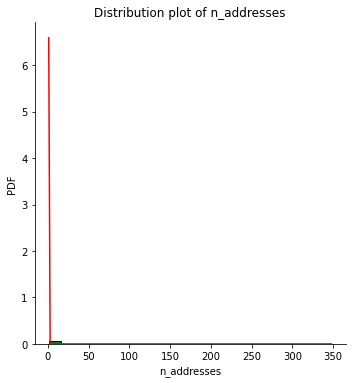

In [11]:
#plot to print distribution of n_addresses

sns.displot(n_addresses, kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution plot of n_addresses')
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

In [12]:
n_addresses = np.sort(np.array(n_addresses))

In [13]:
for i in [50, 75, 90, 95, 99, 100]:
    print('{}\'th percentile: {}'.format(i, np.percentile(n_addresses, i)))
for i in np.arange(99, 99.9, 0.1):
    print('{}\'th percentile: {}'.format(i, np.percentile(n_addresses, i)))

50'th percentile: 1.0
75'th percentile: 1.0
90'th percentile: 1.0
95'th percentile: 1.0
99'th percentile: 3.0
100'th percentile: 348.0
99.0'th percentile: 3.0
99.1'th percentile: 4.0
99.19999999999999'th percentile: 4.0
99.29999999999998'th percentile: 4.0
99.39999999999998'th percentile: 5.0
99.49999999999997'th percentile: 5.0
99.59999999999997'th percentile: 6.0
99.69999999999996'th percentile: 7.0
99.79999999999995'th percentile: 10.0
99.89999999999995'th percentile: 15.0


Since this is an extremely skewed feature let's only visualize the 5th percentile points. Most addresses are repeated only once and a small percentage of them are repeated twice.

In [14]:
fifth_percentile = np.percentile(n_addresses, 99)

n_addresses_fifthpercentile = np.array([element for element in n_addresses if element <= fifth_percentile])

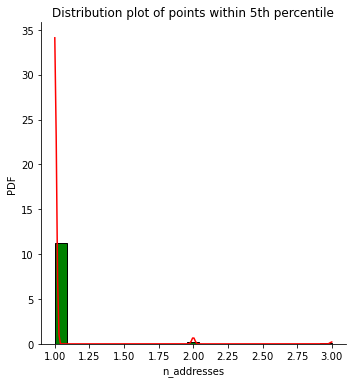

In [15]:
#checking points only within 5th percentile

sns.displot(n_addresses_fifthpercentile, kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution plot of points within 5th percentile')
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

#### 2.1.1.1. Fixing the Skewness for Address Attribute
Since Address is extremely skewed, we need to try to perform some transformation to fix it. The following transformations are conducted:
* log
* square root
* reciprocal
* boxcox 

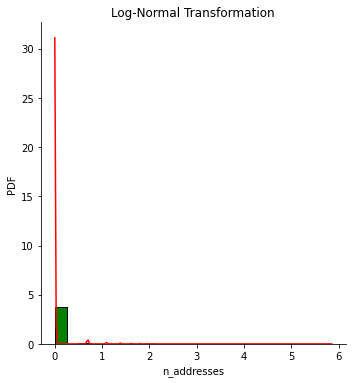

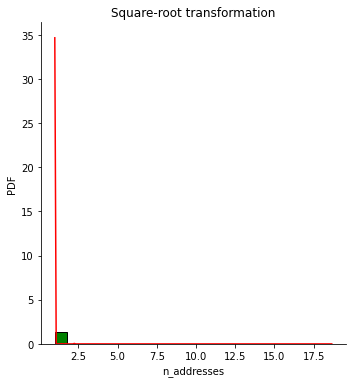

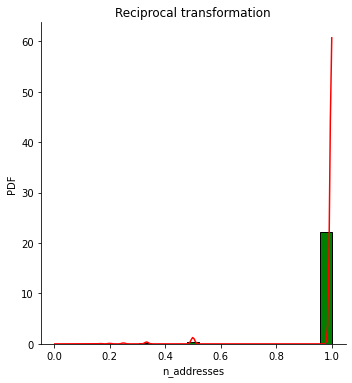

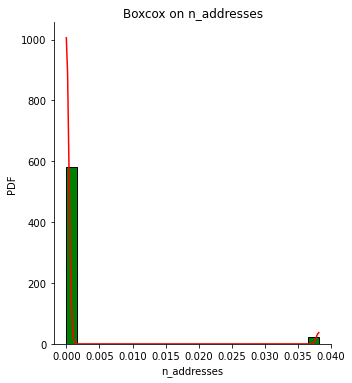

In [16]:
#Checking multiple transforms to see what works best for the feature

#Checking log-transform

sns.displot(np.log(n_addresses), kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
# plt.subplot(311)
plt.title('Log-Normal Transformation')
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

#Checking square-root transform

sns.displot(np.sqrt(n_addresses), kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
# plt.subplot(312)
plt.title('Square-root transformation')
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

#Checking reciprocal transform

sns.displot(1/np.array(n_addresses), kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
# plt.subplot(313)
plt.title('Reciprocal transformation')
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

#Checking boxcox transform

sns.displot(boxcox(n_addresses)[0], kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Boxcox on n_addresses')
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

In [17]:
unique_address_train = X_train.groupby('address').size().to_frame('n_address')

In [18]:
X_train = X_train.merge(unique_address_train, on=['address'], how='left').set_index(X_train.index)

In [19]:
X_train['n_address'] = boxcox(np.array(list(X_train['n_address'])))[0]

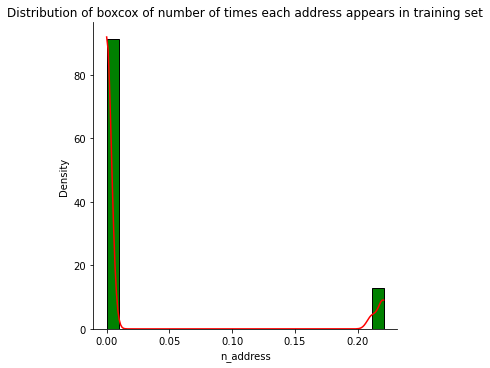

In [20]:
sns.displot(X_train.n_address, kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of boxcox of number of times each address appears in training set')
plt.show()

In [21]:
unique_address_test = X_test.groupby('address').size().to_frame('n_address')

In [22]:
X_test = X_test.merge(unique_address_test, on=['address'], how='left').set_index(X_test.index)

In [23]:
X_test.head()

,address,year,day,length,weight,count,looped,neighbors,income,n_address
428885,18z5kGrm7e3NNq9WXjcKbTCfpEvsBrGsfP,2012,33,4,0.019033,71,0,1,3.020000e+08,1
1819947,1EDjBMxZec3q9PqHyoM6hZDPVtDwRDfCe,2015,329,144,0.009070,3897,0,2,1.000000e+08,1
739086,115gn63LBwn4qMcex3dvr8RVbSisyDW1ji,2012,343,142,0.165386,1609,1609,4,2.566676e+09,1
172467,1NWuBnXkQqHJb8SahQNtDP4a9eLAf4ZPXx,2011,141,10,0.130682,23,0,1,2.180000e+08,3
2691839,1HM4s2JFbhkqDWBMhQFW6NSMGZVK2vgvdE,2018,106,0,1.000000,1,0,2,3.227901e+08,1


In [24]:
X_test['n_address'] = boxcox(np.array(list(X_test['n_address'])))[0]

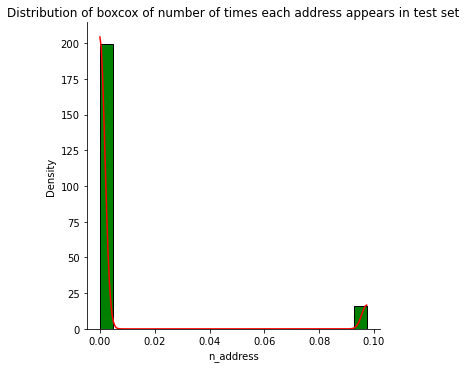

In [25]:
sns.displot(X_test.n_address, kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of boxcox of number of times each address appears in test set')
plt.show()

Constructing new feature: n_address_feature
The feature contains the number of times the address has been seen in the training set (boxcox transformation applied)

### 2.1.2. day
There are some important points about the day feature, which indicates the day of the year that Bitcoin transaction occured. The following points shoul dbe considered, so new features will be constructed to be fed into the predictor model.
* Which quarter of the year the day belongs to?
* Is the day close to a holiday?
* Which day of the week is the day?

#### Looking at its distribution

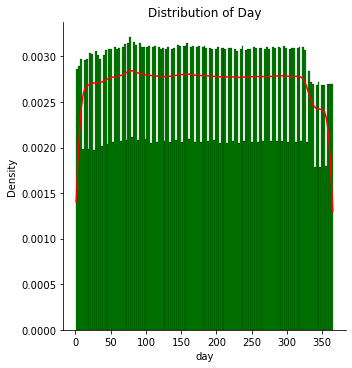

In [26]:
sns.displot(X_train['day'], kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of Day')
plt.show()

#### 2.1.2.1. Constructing new feature: day_of_week
This feature indicates the number of the weekday (for eg: 0 for Monday and 6 for Sunday). The hypothesis is that the day of the week might correlate with the nature of the transaction

In [27]:
X_train['temp_date'] = X_train['year'].astype(str) + "-" + X_train['day'].astype(str)
X_train['Date'] = pd.to_datetime(X_train['temp_date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%j").strftime("%Y-%m-%d")))
X_train['day_of_week'] = X_train['Date'].dt.weekday
X_train.drop(['temp_date'],axis=1,inplace=True)

In [28]:
X_test['temp_date'] = X_test['year'].astype(str) + "-" + X_test['day'].astype(str)
X_test['Date'] = pd.to_datetime(X_test['temp_date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%j").strftime("%Y-%m-%d")))
X_test['day_of_week'] = X_test['Date'].dt.weekday
X_test.drop(['temp_date'],axis=1,inplace=True)

#### 2.1.2.2. Constructing new feature: quarter_number

If th efollowing method is used, taking th eleap years into account would be more challenging. So lets just use the data and time method os Pandas. A new column called 'Date' is generated and day_of_week and quarter_number will be extracted from it.

In [29]:
# bins= [1,92,183,274,365]
# labels = [1,2,3,4]
# X_train['quarter_number'] = pd.cut(X_train.day, bins=bins, labels=labels, right=False)
# X_test['quarter_number'] = pd.cut(X_test.day, bins=bins, labels=labels, right=False)

In [30]:
# using the quarter property
X_train['quarter_number'] = X_train['Date'].dt.quarter
X_test['quarter_number'] = X_test['Date'].dt.quarter

#### 2.1.2.3. Constructing new feature: is_close_to_holiday
This feature indicates if the day number was close to a major public holiday in America.

#### Major Holidays in America:

New Year’s Day, January 1.

Birthday of Martin Luther King, Jr., the third Monday in January.

Washington’s Birthday, the third Monday in February.

Memorial Day, the last Monday in May.

Independence Day, July 4.

Labor Day, the first Monday in September.

Columbus Day, the second Monday in October.

Veterans Day, November 11.

Thanksgiving Day, the fourth Thursday in November.

Christmas Day, December 25.

In [31]:
X_train['temp_date_plus7'] = X_train['Date'] + datetime.timedelta(7)
X_train['temp_date_minus7'] = X_train['Date'] - datetime.timedelta(7)

In [32]:
def holiday_range(df):
    cal = calendar()
    holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
    df['is_close_to_holiday'] = (df['temp_date_plus7'].isin(holidays) | df['temp_date_minus7'].isin(holidays))
    df.drop(['temp_date_plus7', 'temp_date_minus7'],axis=1,inplace=True)
    return df

In [33]:
X_train = X_train.groupby('year').apply(holiday_range)

In [34]:
X_test['temp_date_plus7'] = X_test['Date'] + datetime.timedelta(7)
X_test['temp_date_minus7'] = X_test['Date'] - datetime.timedelta(7)
X_test = X_test.groupby('year').apply(holiday_range)

In [35]:
X_train.drop(['Date'], axis=1, inplace=True)
X_test.drop(['Date'], axis=1, inplace=True)

### 2.1.3. Length
##### Looking at its distribution

[]

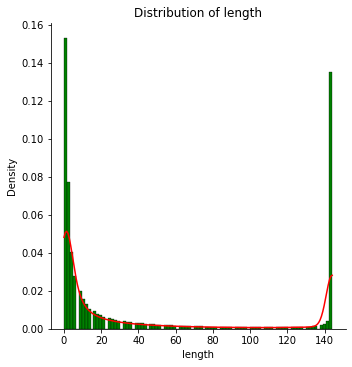

In [36]:
sns.displot(X_train['length'], kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of length')
plt.plot()

#### Constructing new feature: gaussian_length
Feature tries to fix the skewness of the length variable. This is done by applying complex functions over the length feature and then performing a boxcox operation on it

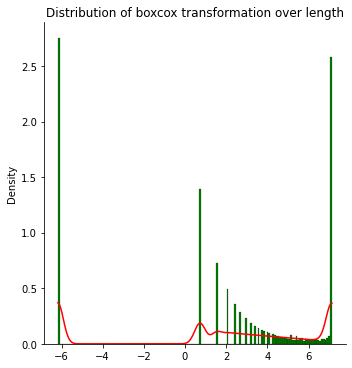

In [37]:
sns.displot(boxcox(np.array(X_train['length']) + 1e-6)[0], kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of boxcox transformation over length')
plt.show()

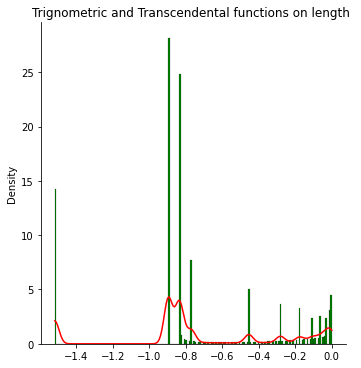

In [38]:
#We can see a sort of 'cyclic' waveform in the above graph. it appears that we have an
#alternating pattern of high and low values. maybe sin transform might help?

sns.displot(boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-6)))) ** 2)[0], kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Trignometric and Transcendental functions on length ')
plt.show()

In [39]:
X_train['gaussian_length'] = boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-6)))) ** 2)[0]
X_test['gaussian_length'] = boxcox((np.sin(np.log(np.sqrt(np.array(X_test['length']) + 1e-6)))) ** 2)[0]

### 2.1.4. Weight
##### Looking at its distribution

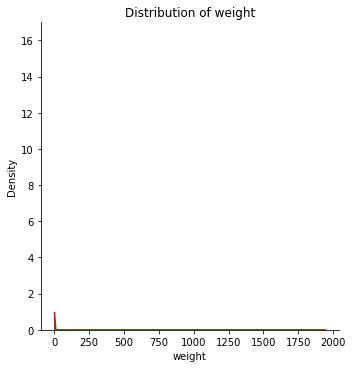

In [40]:
sns.displot(X_train['weight'] , kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of weight')
plt.show()

#### Constructing new feature: gaussian_weight
Feature corrects for the skewedness in weight

C:\Users\lalep\anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


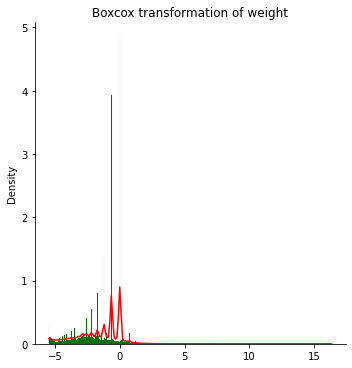

In [41]:
sns.displot(boxcox(np.array(X_train['weight'], dtype=np.longdouble))[0] , kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Boxcox transformation of weight')
plt.show()

Box-cox transformation over weight gives us a much more normal distribution

In [42]:
X_train['gaussian_weight'] = np.array(boxcox(np.array(X_train['weight'],  dtype=np.longdouble))[0])
X_test['gaussian_weight'] = np.array(boxcox(np.array(X_test['weight'],  dtype=np.longdouble))[0])

C:\Users\lalep\anaconda3\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


### 2.1.5. Count
##### Looking at its distribution

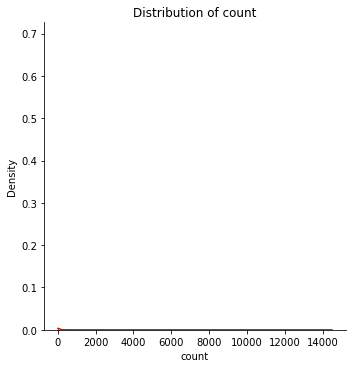

In [43]:
sns.displot(X_train['count'], kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of count')
plt.show()

Again, we see an extremely-skewed log-normal distribution for the Count feature

#### Constructing new feature: log_count
Performing log-transformation to fix skewedness

While performing log to get a normal-distribution still gives us a skewed distribution, it is certainly better than the vanilla feature

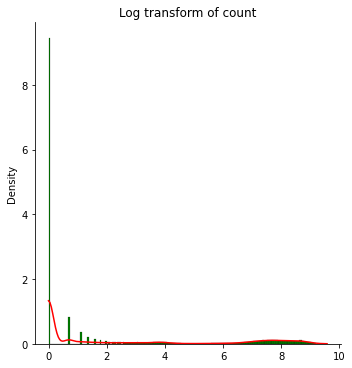

In [44]:
sns.displot(np.log(np.array(X_train['count']) + 1e-6), kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Log transform of count')
plt.show()

In [45]:
X_train['log_count'] = np.log(np.array(X_train['count']) + 1e-6)
X_test['log_count'] = np.log(np.array(X_test['count']) + 1e-6)

### 2.1.6. Loop
##### Looking at its distribution

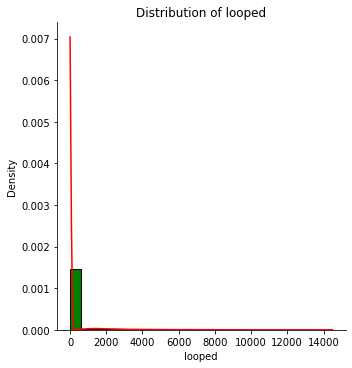

In [46]:
sns.displot(X_train['looped'], kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of looped')
plt.show()

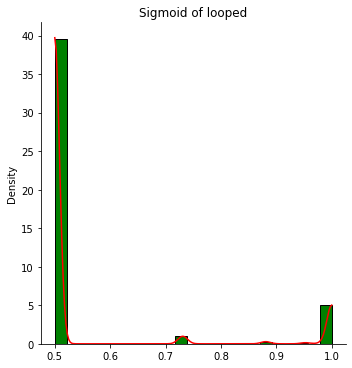

In [47]:
def sigmoid(x):
    #returns the logistic function of x
    
    return 1 / (1 + np.exp(-x))

sns.displot(sigmoid(np.array(X_train['looped'])), kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Sigmoid of looped')
plt.show()

#### Constructing new feature: sigmond_looped
Sigmoidal transformation gives the models a better distribution to work with


In [48]:
X_train['sigmoid_looped'] = sigmoid(np.array(X_train['looped']))
X_test['sigmoid_looped'] = sigmoid(np.array(X_test['looped']))

### 2.1.7. Neighbors
##### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


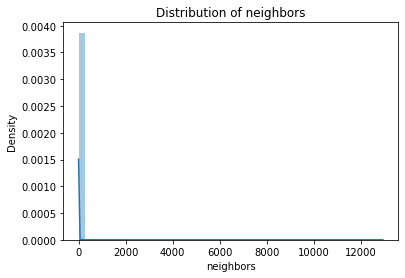

In [49]:
sns.distplot(X_train['neighbors'])
plt.title('Distribution of neighbors')
plt.show()

#### Constructing a new feature: gaussian_neighbors
Feature tries to account for the extreme skewedness of neighbors by applying boxcox transformation

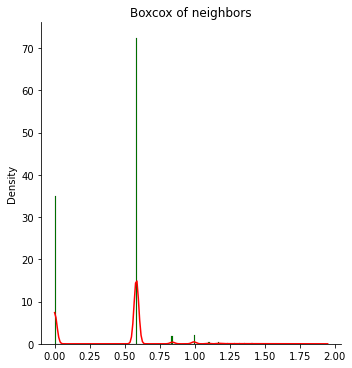

In [50]:
sns.displot(boxcox(np.array(X_train['neighbors']) + 1e-6)[0], kde=True, facecolor='green', color='red',edgecolor='black', stat="density")
plt.title('Boxcox of neighbors')
plt.show()

Boxcox transformation over Neighbors gives us a slighly more gaussian distribution

In [51]:
X_train['gaussian_neighbors'] = boxcox(np.array(X_train['neighbors']) + 1e-6)[0]
X_test['gaussian_neighbors'] = boxcox(np.array(X_test['neighbors']) + 1e-6)[0]

### 2.1.8. Income
##### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


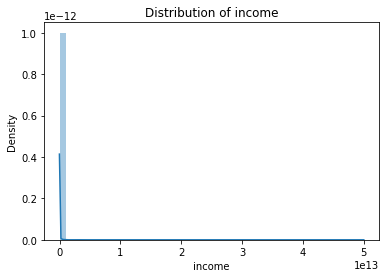

In [52]:
sns.distplot(X_train['income'])
plt.title('Distribution of income')
plt.show()

#### Constructing a new feature: gaussian_income
Feature tries to account for the extreme skewedness of income by applying boxcox transformation

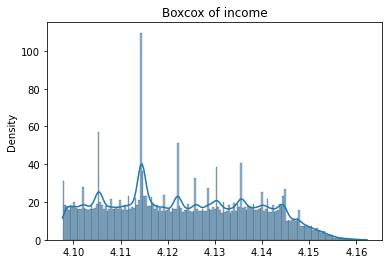

In [53]:
sns.histplot(boxcox(np.array(X_train['income']) + 1e-6)[0], kde=True, stat="density")
plt.title('Boxcox of income')
plt.show()

In [54]:
X_train['gaussian_income'] = boxcox(np.array(X_train['income']) + 1e-6)[0]
X_test['gaussian_income'] = boxcox(np.array(X_test['income']) + 1e-6)[0]

## 2.2. Constrcting Complex Features
### 2.2.1. Interaction Featres
#### 2.2.1.1. Between Length and Weight

In [55]:
median_length = np.median(X_train['length'])
median_weight = np.median(X_train['weight'])
X_train['interaction_length_weight'] = 2

In [56]:
X_train['interaction_length_weight'][X_train.index[(X_train['length'] > median_length) & (X_train['weight'] > median_weight)]] = 0
X_train['interaction_length_weight'][X_train.index[(X_train['length'] > median_length) & (X_train['weight'] <= median_weight)]] = 1


<ipython-input-56-fa411cc44007>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['interaction_length_weight'][X_train.index[(X_train['length'] > median_length) & (X_train['weight'] > median_weight)]] = 0
<ipython-input-56-fa411cc44007>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['interaction_length_weight'][X_train.index[(X_train['length'] > median_length) & (X_train['weight'] <= median_weight)]] = 1


In [57]:
median_length = np.median(X_test['length'])
median_weight = np.median(X_test['weight'])
X_test['interaction_length_weight'] = 2

In [58]:
X_test['interaction_length_weight'][X_test.index[(X_test['length'] > median_length) & (X_test['weight'] > median_weight)]] = 0
X_test['interaction_length_weight'][X_test.index[(X_test['length'] > median_length) & (X_test['weight'] <= median_weight)]] = 1


<ipython-input-58-f03263175e1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['interaction_length_weight'][X_test.index[(X_test['length'] > median_length) & (X_test['weight'] > median_weight)]] = 0
<ipython-input-58-f03263175e1e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['interaction_length_weight'][X_test.index[(X_test['length'] > median_length) & (X_test['weight'] <= median_weight)]] = 1


#### 2.2.1.2 Between log-count and gaussian-income


In [59]:
median_count = np.median(X_train['log_count'])
median_income = np.median(X_train['gaussian_income'])
X_train['interaction_count_income'] = 2

In [60]:
X_train['interaction_count_income'][X_train.index[(X_train['log_count'] > median_count) & (X_train['gaussian_income'] > median_income)]] = 0
X_train['interaction_count_income'][X_train.index[(X_train['log_count'] > median_count) & (X_train['gaussian_income'] <= median_income)]] = 1


<ipython-input-60-d753377cd89d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['interaction_count_income'][X_train.index[(X_train['log_count'] > median_count) & (X_train['gaussian_income'] > median_income)]] = 0
<ipython-input-60-d753377cd89d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['interaction_count_income'][X_train.index[(X_train['log_count'] > median_count) & (X_train['gaussian_income'] <= median_income)]] = 1


In [61]:
median_count = np.median(X_test['log_count'])
median_income = np.median(X_test['gaussian_income'])
X_test['interaction_count_income'] = 2

In [62]:
X_test['interaction_count_income'][X_test.index[(X_test['log_count'] > median_count) & (X_test['gaussian_income'] > median_income)]] = 0
X_test['interaction_count_income'][X_test.index[(X_test['log_count'] > median_count) & (X_test['gaussian_income'] <= median_income)]] = 1


<ipython-input-62-b1a25dcd7622>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['interaction_count_income'][X_test.index[(X_test['log_count'] > median_count) & (X_test['gaussian_income'] > median_income)]] = 0
<ipython-input-62-b1a25dcd7622>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['interaction_count_income'][X_test.index[(X_test['log_count'] > median_count) & (X_test['gaussian_income'] <= median_income)]] = 1


In [63]:
X_train.head()

,address,year,day,length,weight,count,looped,neighbors,income,n_address,...,quarter_number,is_close_to_holiday,gaussian_length,gaussian_weight,log_count,sigmoid_looped,gaussian_neighbors,gaussian_income,interaction_length_weight,interaction_count_income
2264511,366ZrW8BbPeK21L7bwTJkzKqEfKJceJpKm,2017,43,0,0.500000,1,0,2,31515644.0,0.0,...,1,False,-0.895193,-0.651137,9.999995e-07,0.5,5.841690e-01,4.098487,2,2
1289376,1Nyy3jRxjmt9dCWPe5LvnSZhArnSfjAykR,2014,163,4,0.040000,1,0,2,100000000.0,0.0,...,2,False,-0.769382,-2.434900,9.999995e-07,0.5,5.841690e-01,4.114446,2,2
1046802,1B9zENZjbkFxwdjHSmAyqXrPq5FLb9vDmZ,2013,286,2,0.500000,1,0,1,81050000.0,0.0,...,4,False,-1.517133,-0.651137,9.999995e-07,0.5,9.999992e-07,4.111862,2,2
2335966,35hfQ92WkncKrupG9NVtSmScvKXXkBfnPD,2017,115,92,1.016858,72,0,2,100030000.0,0.0,...,2,False,-0.475286,0.016743,4.276666e+00,0.5,5.841690e-01,4.114450,0,1
1214724,1Bmm4KkZuzdzEjKtVmtTVyQoVKEE1J4wmz,2014,89,144,0.028767,1189,1187,4,184953990.0,0.0,...,1,False,-0.835022,-2.612813,7.080868e+00,1.0,9.948198e-01,4.121303,1,1


## 2.3. Data Preparation for Modeling
### 2.3.1. Distance Based Models

In [64]:
'''
'address' : To be dropped
'year' : To be standardized
'day' : To be standardized
'length' : To be standardized
'weight' : To be standardized 
'count' : To be standardized
'looped' : To be standardized
'neighbors' : To be standardized
'income' : To be standardized
'n_address' : To be standardized
'day_of_week' : To be One hot encoded
'is_close_to_holiday', : Binary feature. To be left as is 
'quarter_number' : To be One hot encoded
'gaussian_income' : To be standardized
'gaussian_neighbors' : To be standardized
'gaussian_weight' : To be standardized
'gaussian_length' : To be standardized
'log_count' : To be standardized
'sigmoid_looped' : To be standardized
'interaction_count_income' : To be One Hot encoded
'interaction_length_weight' : To be One hot encoded
'''
pass

In [65]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [66]:
#Scale the data

col_names_standardize = [
    'year',
    'day',
    'length',
    'weight',
    'count',
    'looped',
    'neighbors',
    'income',
    'n_address',
    'gaussian_income',
    'gaussian_neighbors',
    'gaussian_weight',
    'gaussian_length',
    'log_count',
    'sigmoid_looped'
]
#encode the data

col_names_encode = [
    'day_of_week',
    'quarter_number',
    'interaction_count_income',
    'interaction_length_weight'
]

transformer = ColumnTransformer([
    ('standardize', StandardScaler(), col_names_standardize),
    ('encode', OneHotEncoder(), col_names_encode)
], remainder = 'passthrough')

transformer.fit(X_train.drop(['address'], axis=1))

X_train_distance = transformer.transform(X_train.drop(['address'], axis=1))
X_test_distance = transformer.transform(X_test.drop(['address'], axis=1))

### 2.4.2. tree Based Models
Don't need to perform standardization or encoding for tree based models


In [67]:
X_train_tree, X_test_tree = X_train.drop(['address'], axis=1).to_numpy(), X_test.drop(['address'], axis=1).to_numpy()

In [68]:
pd.DataFrame(X_train_tree).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2017,43,0,0.5,1,0,2,31515644.0,0.0,6,1,False,-0.895193,-0.651137,0.000001,0.5,0.584169,4.098487,2,2
1,2014,163,4,0.04,1,0,2,100000000.0,0.0,3,2,False,-0.769382,-2.4349,0.000001,0.5,0.584169,4.114446,2,2
2,2013,286,2,0.5,1,0,1,81050000.0,0.0,6,4,False,-1.517133,-0.651137,0.000001,0.5,0.000001,4.111862,2,2
3,2017,115,92,1.016858,72,0,2,100030000.0,0.0,1,2,False,-0.475286,0.016743,4.276666,0.5,0.584169,4.11445,0,1
4,2014,89,144,0.028767,1189,1187,4,184953990.0,0.0,6,1,False,-0.835022,-2.612813,7.080868,1.0,0.99482,4.121303,1,1


## 3. Uni-variate analysis
* Univariate analysis is the technique of comparing and analyzing the dependency of a single predictor and a response variable. The prefix "uni" means one, emphasizing the fact that the analysis only accounts for one variable's effect on a dependent variable
* In this section we will look at our features' Probabiliy Density Function (PDF) which gives us the relative likelihood of a random variable taking a value in a specific range.
* Ideally these PDF's should be normally distributed, meaning they should look like a bell curve because some of our models have naive assumptions of the data-set they operate on.
* For this reason, if they are not normally distributed, we will modify them by applying transformation functions to better suit our needs
* We will also plot PDF's of features whose datapoints belong to class 0 and 1 separately. This will help us see if there is any difference in the PDF's. If there is, our models perform better.

### 3.1. Data dictionary

#### 3.1.1. Vanilla features

1. address [String]: Stores the address of the bitcoin transaction.

2. year [int]      : Indicates the year in which the transaction has been done.

3. day [int]       : Indicates day of the year.

4. length [int]    : Length is designed to quantify mixing rounds on Bitcoin, where transactions receive and distribute                             similar amounts of coins in multiple rounds with newly created addresses to hide the coin origin.

5. weight [float]  : Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output                               addresses), where coins in multiple addresses are each passed through a succession of merging                                   transactions and accumulated in a final address.
6. count [int]     : Similar to weight, the count feature is designed to quantify the merging pattern. However, the count                           feature represents information on the number of transactions, whereas the weight feature represents                             information on the amount of transaction.
7. looped [int]    : Loop is intended to count how many transaction i) split their coins; ii) move these coins in the                               network by using different paths and finally, and iii) merge them in a single address. Coins at this                           final address can then be sold and converted to fiat currency.

8. neighbors [int] : Indicates the number of neighbors a transcation had.

9. income [int]    : Income in terms of Satoshi amount where a Satoshi is the smallest unit of a bitcoin, equivalent to 100                         millionth of a bitcoin.

#### 3.1.2. Engineered features

1. n_address [int]: Indicates number of times the unique address has been seen in training set.

2. day_of_week [int]: Indicates day number. For example, 0 for Monday and 6 for Sunday.

3. is_close_to_holiday [Binary]: Indicator variable. 1 if transaction has been made during a public holiday in America; 0 otherwise.

4. quarter_number [int]: Indicates the quarter (Q1, .. Q4) in which the transaction has been made

5. gaussian_income [float]: Gaussianized income
6. gaussian_neighbors [float]: Gaussianized neighbors

7. gaussian_weight [float]: Gaussianized weight

8. gaussian_length [float]: Gaussianized length

9. log_count [float]: Log transformed count

10. sigmoid_looped [float]: Logistic function of looped

11. interaction_count_income [float]: Interaction feature between count and income

12. interaction_length_weight [float]: Interaction feature between length and weight

### 3.2. Basic Statistics

In [69]:
print('Training set has {} rows and {} columns'.format(X_train.shape[0], X_train.shape[1]))

Training set has 2333357 rows and 21 columns


In [70]:
print('Training set has {} points that belong to postitive class (Malware) and {} points that belong to negative class (Clean)'.format(
    sum(y_train),
    len(y_train) - sum(y_train)
))

Training set has 33130 points that belong to postitive class (Malware) and 2300227 points that belong to negative class (Clean)


In [71]:
print('Testing set has {} rows and {} columns'.format(X_test.shape[0], X_test.shape[1]))

Testing set has 583340 rows and 21 columns


In [72]:
print('Testing set has {} points that belong to postitive class (Malware) and {} points that belong to negative class (Clean)'.format(
    sum(y_test),
    len(y_test) - sum(y_test)
))

Testing set has 8283 points that belong to postitive class (Malware) and 575057 points that belong to negative class (Clean)


In [73]:
print('Percentage of positive class data-points: {}%'.format((sum(y_train)/(len(y_train)) * 100)))

Percentage of positive class data-points: 1.4198427415950496%


In [74]:
undersampled_y = y_train[y_train==0]
undersampled_df = X_train.loc[undersampled_y.index]
print(len(undersampled_y), len(undersampled_df))
undersampled_df['random'] = np.random.uniform(0,1, undersampled_df.shape[0])
undersampled_df = undersampled_df[undersampled_df['random'] < 0.015]
print('after undersampling: ',len(undersampled_df))

2300227 2300227
after undersampling:  34454


In [75]:
positive_y = y_train[y_train==1]
positive_df = X_train.loc[positive_y.index]
print(len(positive_y), len(positive_df))

33130 33130


In [76]:
print('Undersampled dataframe has {} rows and {} columns'.format(undersampled_df.shape[0], undersampled_df.shape[1]))

Undersampled dataframe has 34454 rows and 22 columns


### 3.3. Univariate Analysis of Features
#### 3.3.1. n_address
* Feature indicates the number of times addresss has appeared in training data.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

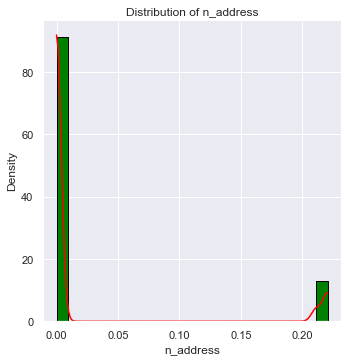

In [77]:
#Distribution of n_address

sns.set_theme('notebook')
sns.displot(X_train['n_address'], kde=True, facecolor='green', color='red',edgecolor='black', stat='density')
plt.title('Distribution of n_address')
plt.show()

[]

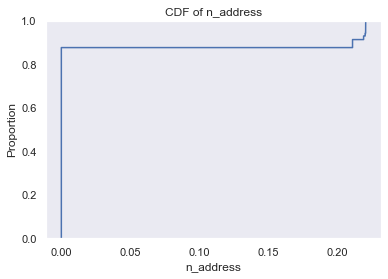

In [78]:
#plotting its cdf

sns.ecdfplot(X_train, x='n_address')
plt.title('CDF of n_address')
plt.grid()
plt.plot()

#### White vs Ransom Distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


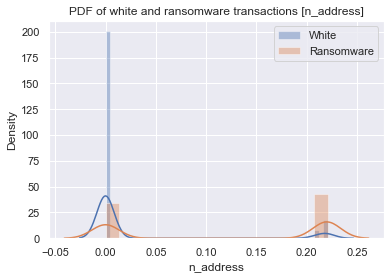

In [79]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['n_address'], label = 'White')
sns.distplot(positive_df['n_address'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [n_address]')
plt.show()

We notice that there is quite a lot of separability between the two-classes in their respective PDFs

#### 3.3.2. Year
* Feature indicates what year the transaction had taken place in.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

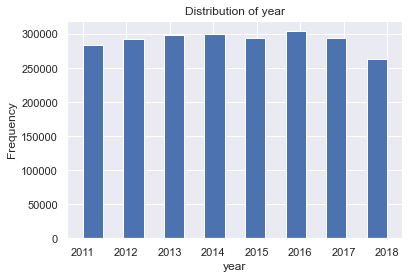

In [80]:
#Displaying histogram of year feature

X_train['year'].plot(kind = 'hist', bins=15)
plt.xlabel('year')
plt.title('Distribution of year')
plt.show()

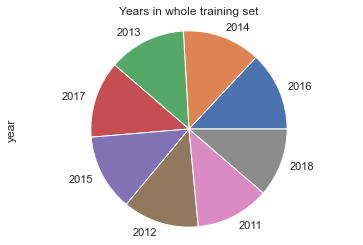

In [81]:
#displaying pie-chart

X_train['year'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Years in whole training set')
plt.show()

#### White vs Ransom Distribution

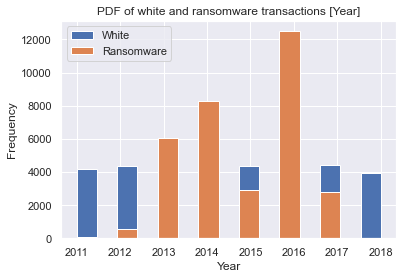

In [82]:
#checking to see if the year in which the transaction has been made has any correlation with the transaction

undersampled_df['year'].plot(kind = 'hist', bins=15, label='White')
positive_df['year'].plot(kind = 'hist', bins=15, label='Ransomware')
plt.xlabel('year')
plt.title('PDF of white and ransomware transactions [Year]')
plt.xlabel('Year')
plt.legend()
plt.show()

Transactions made in 2011, 2012 and 2018 are far more likely to be white rather than ransomware


#### 3.3.3. Day
* Feature indicates the day number of the year on which the transaction took place.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


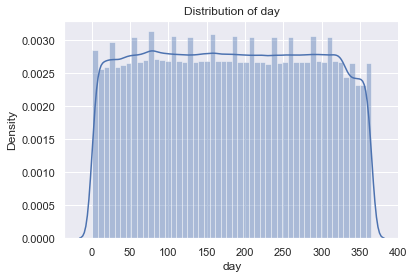

In [83]:
#plotting pdf

sns.distplot(X_train['day'])
plt.title('Distribution of day')
plt.show()

Days looks to be pretty uniformly distributed


#### White vs Ransom Distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


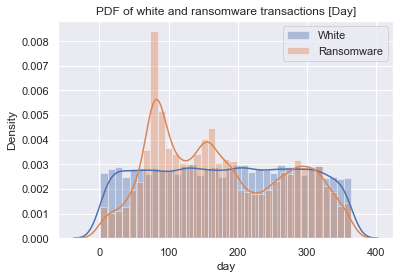

In [84]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['day'], label = 'White')
sns.distplot(positive_df['day'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Day]')
plt.show()

The two functions seem to be distinguishable on certain days. For example, on day 95 the transactions are far more likely to be white rather than ransomware


#### 3.3.4. Length
* Feature indicates the mixing rounds on Bitcoin, where transactions receive and distribute similar amounts of coins in multiple rounds with newly created addresses to hide the coin origin.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


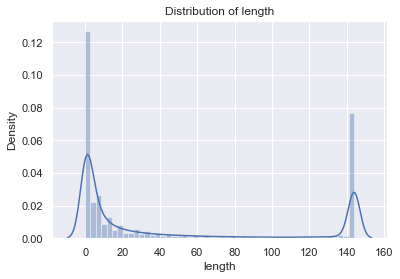

In [85]:
#plotting pdf

sns.distplot(X_train['length'])
plt.title('Distribution of length')
plt.show()

#### White vs Ransom Distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


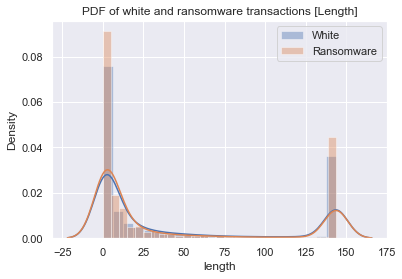

In [86]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['length'], label = 'White')
sns.distplot(positive_df['length'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Length]')
plt.show()
# The distributions look almost indistinguishable

#### 3.3.5. Weight
* Feature indicates the merge behavior
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


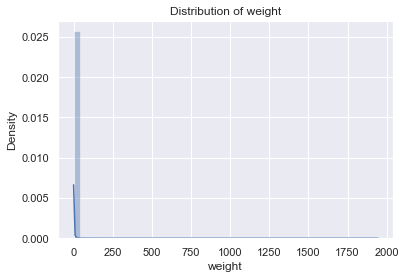

In [87]:
#plotting pdf

sns.distplot(X_train['weight'])
plt.title('Distribution of weight')
plt.show()

#### White vs Ransom Distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


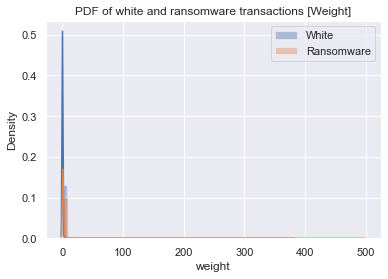

In [88]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['weight'], label = 'White')
sns.distplot(positive_df['weight'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Weight]')
plt.show()

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


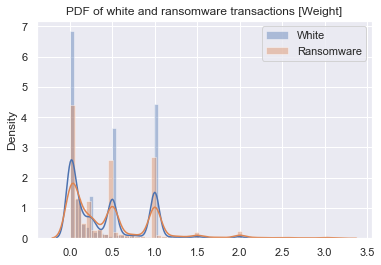

In [89]:
#Printing pdf's for 98th percentile to zoom in

sns.distplot([i for i in undersampled_df['weight'] if i < np.percentile(undersampled_df['weight'], 98)], label = 'White')
sns.distplot([i for i in positive_df['weight'] if i < np.percentile(positive_df['weight'], 98)], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Weight]')
plt.show()

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


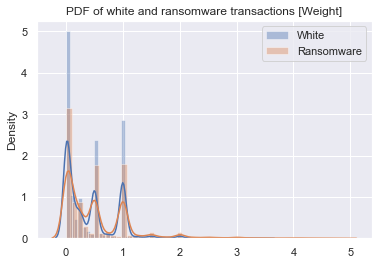

In [90]:
#printing PDF for 99th percentile to zoom in further

sns.distplot([i for i in undersampled_df['weight'] if i < np.percentile(undersampled_df['weight'], 99)], label = 'White')
sns.distplot([i for i in positive_df['weight'] if i < np.percentile(positive_df['weight'], 99)], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Weight]')
plt.show()
#It seems like probability of a transction being ransomware is higher when at higher densities at peeks in the PDF of weight


#### 3.3.6. Count
* Feature indicates the merging pattern.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


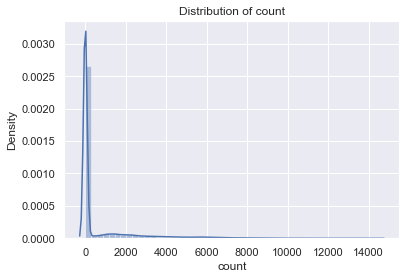

In [91]:
#plotting pdf

sns.distplot(X_train['count'])
plt.title('Distribution of count')
plt.show()

#### White vs Ransom Distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


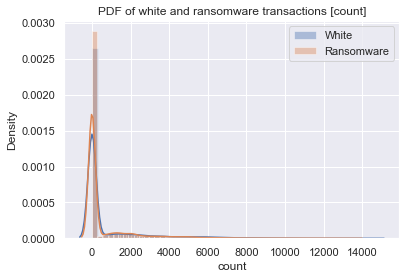

In [92]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['count'], label = 'White')
sns.distplot(positive_df['count'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [count]')
plt.show()
#We notice very little separability between the two-classes


#### 3.3.7. Looped
* Feature indicates how many transaction i) split their coins; ii) move these coins in the network by using different paths and finally, and iii) merge them in a single address.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


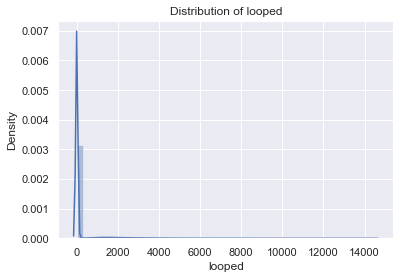

In [93]:
#plotting pdf

sns.distplot(X_train['looped'])
plt.title('Distribution of looped')
plt.show()

#### White vs Ransom Distribution

[]

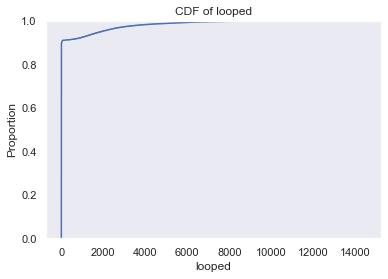

In [94]:
sns.ecdfplot(X_train, x='looped')
plt.title('CDF of looped')
plt.grid()
plt.plot()

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


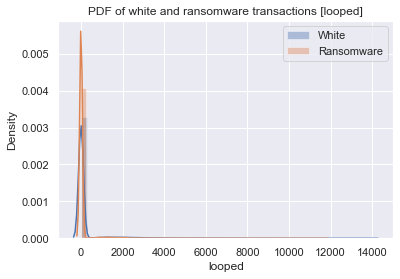

In [95]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['looped'], label = 'White')
sns.distplot(positive_df['looped'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [looped]')
plt.show()
#We notice quite a lot of separability when the value of looped is around '0'. However, above 500, there appears to be no separability.


#### 3.3.8. Neighbors
* Feature indicates number of neighbours a transaction had.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


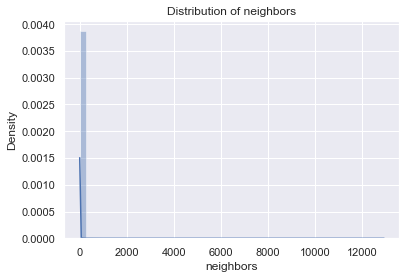

In [96]:
#Distribution of neighbors

sns.distplot(X_train['neighbors'])
plt.title('Distribution of neighbors')
plt.show()

[]

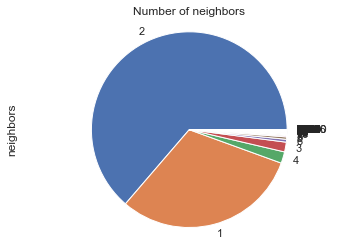

In [97]:
X_train.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Number of neighbors')
plt.plot()
#It seems that most data-points have 2 neighbors


[]

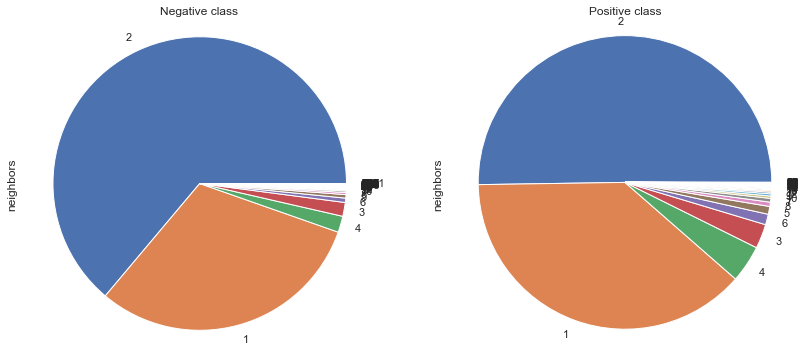

In [98]:
plt.figure(figsize=(14, 6))

#plotting piechart of negative class
plt.subplot(121)
undersampled_df.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Negative class')
plt.plot()


plt.subplot(122)
positive_df.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Positive class')
plt.plot()
#It's clear that both positive classes and negative classes follow considerably different distributions


#### 3.3.9. Income
* Let us see how the income generated changes with the target variable

#### Looking at its distribution

C:\Users\lalep\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


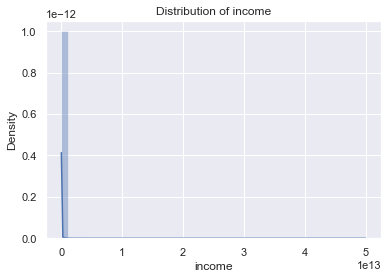

In [99]:
#plotting pdf

sns.distplot(X_train['income'])
plt.title('Distribution of income')
plt.show()

In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(np.array([i for i in undersampled_df['income'] if i < np.percentile(undersampled_df.income, 99)]), label = 'White')
sns.distplot(np.array([i for i in positive_df['income'] if i < np.percentile(positive_df.income, 99)]), label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [income]')
plt.show()
#It's evident that ransomware transactions usually contain a higher amount of income


#### 3.3.10. Day of the Week
* Let us see how the target variable changes with the day of week

#### Looking at its distribution

In [ ]:
#Displaying histogram of day_of_week feature

X_train['day_of_week'].plot(kind = 'hist', bins=13)
plt.xlabel('day_of_week')
plt.title('Distribution of day_of_week')
plt.xlabel('Days')
plt.show()

In [ ]:
#Displaying histogram of day_of_week feature

undersampled_df['day_of_week'].plot(kind = 'hist', bins=13, label='White')
positive_df['day_of_week'].plot(kind = 'hist', bins=13, label='Ransomware')
plt.xlabel('day_of_week')
plt.title('Distribution of day_of_week')
plt.xlabel('Days')
plt.legend()
plt.show()
#It seems that transactions done over the week are far more likely to be white than ransomware


#### 3.3.11. Is Close to Holiday
* Let us see if transactions are more (or less) likely to be fraudulent during the holidays

#### Looking at its distribution

In [ ]:
#displaying pie-chart

X_train['is_close_to_holiday'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('is_close_to_holidays in whole training set')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

#plotting piechart of negative class
plt.subplot(121)
undersampled_df.is_close_to_holiday.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Negative class')
plt.plot()


plt.subplot(122)
positive_df.is_close_to_holiday.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Positive class')
plt.plot()

In [ ]:
#Displaying histogram of is_close_to_holiday feature

undersampled_df['is_close_to_holiday'].value_counts().plot(kind = 'hist', bins=4, label='White')
positive_df['is_close_to_holiday'].value_counts().plot(kind = 'hist', bins=4, label='Ransomware')
plt.xlabel('is_close_to_holiday')
plt.title('Distribution of is_close_to_holiday')
plt.xlabel('0 - No, 1 - Yes')
plt.xticks([0, 1])
plt.legend()
plt.show()
#Transactions done during holidays are slightly more likely to be white rather than ransomware


#### 3.3.12. Quarter Number
* Let us see if the quarter of the year affects the target variable

#### Looking at its distribution

In [ ]:
#displaying pie-chart
#### White vs Ransom Distributionain
X_train['quarter_number'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('quarter_numbers in whole training set')
plt.show()
#Looks pretty symmtetric


#### White vs Ransom Distribution

In [ ]:
#Displaying histogram of quarter_number feature

undersampled_df['quarter_number'].plot(kind = 'hist', bins=8, label='White')
positive_df['quarter_number'].plot(kind = 'hist', bins=8, label='Ransomware')
plt.xlabel('quarter_number')
plt.title('Distribution of quarter_number')
plt.xlabel('Quarter number')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()
#Transactions made in the third and fourth quarter are more likely to be white rather than ransomware


#### 3.3.12. Gaussian Income
* Feature corrects for the skewness in Income feature. Let us see how it changes with the target variable.
#### Looking at its distribution

In [ ]:
#plotting pdf

sns.displot(X_train['gaussian_income'], kde=True, facecolor='green', color='red',edgecolor='black')
plt.title('Distribution of gaussian_income')
plt.show()

#### White vs Ransom Distribution

In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['gaussian_income'], label = 'White')
sns.distplot(positive_df['gaussian_income'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_income]')
plt.show()
#There is a considerable amount of difference in both the distributions


#### 3.3.12. Gaussian Neighbors
* Feaute corrects for skewness in neighhbors feature. Let us see how it affects the target variable.
#### Looking at its distribution

In [ ]:
#plotting pdf

sns.displot(X_train['gaussian_neighbors'], kde=True, facecolor='green', color='red',edgecolor='black')
plt.title('Distribution of gaussian_neighbors')
plt.show()

#### White vs Ransom Distribution

In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['gaussian_neighbors'], label = 'White')
sns.distplot(positive_df['gaussian_neighbors'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_neighbors]')
plt.show()
#The PDF's have a little difference around the 0.5-0.7 mark


#### 3.3.12. Gaussian Weight
* Feature corrects for skewness in weight feature. Let us see how it affects the target variable.
#### Looking at its distribution

In [ ]:
#plotting pdf

sns.displot(X_train['gaussian_weight'], kde=True, facecolor='green', color='red',edgecolor='black')
plt.title('Distribution of gaussian_weight')
plt.show()

#### White vs Ransom Distribution


In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['gaussian_weight'], label = 'White')
sns.distplot(positive_df['gaussian_weight'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_weight]')
plt.show()
#We notice a slight amount of separability between the two classes


#### 3.3.12. GaussianLength
* Feature corrects for skewness in length feature. Let us see how it affects the target variable.
#### Looking at its distribution

In [ ]:
#plotting pdf

sns.displot(X_train['gaussian_length'], kde=True, facecolor='green', color='red',edgecolor='black')
plt.title('Distribution of gaussian_length')
plt.show()

#### White vs Ransom Distribution

In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['gaussian_length'], label = 'White')
sns.distplot(positive_df['gaussian_length'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_length]')
plt.show()
#The PDFs look almost identical, thereby indicating no amount of separability.


#### 3.3.12. Log Count
* Feature corrects for skewness in count feature. Let us see how it affects the target variable.
#### Looking at its distribution

In [ ]:
#plotting pdf

sns.displot(X_train['log_count'], kde=True, facecolor='green', color='red',edgecolor='black')
plt.title('Distribution of log_count')
plt.show()

#### White vs Ransom Distribution

In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['log_count'], label = 'White')
sns.distplot(positive_df['log_count'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [log_count]')
plt.show()

#### 3.3.12. Sigmond Looped
* Feature corrects for skewness in looped feature. Let us see how it affects the target variable.
#### Looking at its distribution

In [ ]:
#plotting pdf

sns.displot(X_train['sigmoid_looped'], kde=True, facecolor='green', color='red',edgecolor='black')
plt.title('Distribution of sigmoid_looped')
plt.show()

#### White vs Ransom Distribution

In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['sigmoid_looped'], label = 'White')
sns.distplot(positive_df['sigmoid_looped'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [sigmoid_looped]')
plt.show()
#We see that this engineered feature gives us some amount of separability when the value is between 0.4 and 0.6


#### 3.3.12. Interaction: count and income
* Feature has been engineered by applying transformation functions on count and income and combining them. Let us see how it affects our target variable.
#### Looking at its distribution

In [ ]:
#displaying pie-chart

X_train['interaction_count_income'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('interaction_count_incomes in whole training set')
plt.show()

#### White vs Ransom Distribution

In [ ]:
#Displaying histogram of interaction_count_income feature

undersampled_df['interaction_count_income'].plot(kind = 'hist', bins=5, label='White')
positive_df['interaction_count_income'].plot(kind = 'hist', bins=5, label='Ransomware')
plt.xlabel('interaction_count_income')
plt.title('Distribution of interaction_count_income')
plt.xlabel('Interaction feature between count and income')
plt.xticks([0, 1, 2])
plt.legend()
plt.show()
#Transactions with this feature being equal to 1 and 2 are slightly more likely to be white


#### 3.3.12. Interaction: Weight and Length
* Feature has been engineered by applying transformation functions on weight and length and combining them. Let us see how it affects our target variable.
#### Looking at its distribution

In [ ]:
#displaying pie-chart

X_train['interaction_length_weight'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('interaction_length_weights in whole training set')
plt.show()

#### White vs Ransom Distribution

In [ ]:
#Displaying histogram of interaction_length_weight feature

undersampled_df['interaction_length_weight'].plot(kind = 'hist', bins=5, label='White')
positive_df['interaction_length_weight'].plot(kind = 'hist', bins=5, label='Ransomware')
plt.xlabel('interaction_length_weight')
plt.title('Distribution of interaction_length_weight')
plt.xlabel('Interaction feature between length and weight')
plt.xticks([0, 1, 2])
plt.legend()
plt.show()
#Transactions with this feature being equal to 1 is significanly more probable to be white than ransomware


#### 3.3.12. Target Variable
* This is the variable we wish to predict. Let us see how it is distributed
#### Looking at its distribution

In [ ]:
#code to print pie chart

print('\t Distribution of target variable')
labels = [0, 1]
sizes = [pd.Series(y_train).value_counts()[0], pd.Series(y_train).value_counts()[1]]
explode = (0, 0.1)
colors = ['#66b3ff','#ffcc99']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [ ]:
#count plot

sns.set_theme(style='darkgrid')
sns.countplot(y_train)
plt.title('Target variable distribution in whole training set')
plt.show()
#Like we expected, it an extremely imbalanced data-set


## 4. Multi-variate analysis
Multivariate analysis (MVA) is based on the principles of multivariate statistics, which involves observation and analysis of more than one statistical outcome variable at a time. Typically, MVA is used to address the situations where multiple measurements are made on each experimental unit and the relations among these measurements and their structures are important.

In [ ]:
#Creating a new dataframe with same number of positive and negative class datapoints

balanced_df = undersampled_df.sample(500)
balanced_df = balanced_df.append(positive_df.sample(500))
balanced_df['labels'] = np.append([0] * 500, [1] * 500)

In [ ]:
balanced_df.head()

### Pair plots
Pairs plots let us see how points in a feature are distributed with respect to other features.

In [ ]:
#plotting pair plots

sns.set_theme(style='ticks')
sns.pairplot(balanced_df[['gaussian_length',
                      'gaussian_weight',
                      'gaussian_income',
                      'gaussian_neighbors',
                      'log_count',
                      'labels'
                     ]], hue='labels')


plt.title('Pair-plot')
plt.plot()

### Correlations
Correlation is a term that is a measure of the strength of a linear relationship between two quantitative variables (e.g., height, weight).

In [ ]:
X_train.corr()

### Correlation map
Correlation map shows how correlated sets of features are. Darker the color in the box, higher is the correlation between the corresponding features

In [ ]:
#plotting correlation map
# +1 and -1 mean fully-correlated features

corr = X_train.corr()
plt.figure(figsize=(14, 14))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### 4.1. Gaussian income and log count
Gaussian-income and log-count fix the skewnesss of the respective features by applying transformations. Generally speaking, for models like Logistic Regression, maximum predictive power can be achieved if the features are distributed normally or if their PDF looks like a 'bell curve'.

We now visualize how both of these features when combined, affect our target variable

In [ ]:
#plotting kde maps
#KDE or Kernel Density Maps plot the probability density of a continous variable
#probability density of a continous variable gives us the probability of find a continous variable at a particular interval
#of points.

#In the below plot, smaller the 'circle', higher is the probability density function of the combined variables (since we're
#using 2D KDE plot to measure affect of two variables at the same time)

sns.jointplot(data=balanced_df, x='gaussian_income', y='log_count', hue='labels', kind = 'kde')
plt.plot()

In the above plot, we want the blue lines and orange lines two be as separable as possible. If they are completely overlapping, that means the feature does not change whether the target variable is 1 or 0. However, in our case, there is a considerable amount of separability so these features will definetely contribute to predicting the target variable.
The combined distributions look similar but when income is high, for positive class, log_count is more widely spread than negative class

In [ ]:
#plotting lm plots

#lm plots are just scatter plots. they let us see how features change with respect to other features

sns.lmplot(x='gaussian_income', y='log_count', hue='labels', data=balanced_df, fit_reg = False)
plt.plot()

### 4.2 Gaussian length and gaussian weight
Gaussian length and gaussian weight also correct the skewness of their original feature values. We now visualize how when both of these features are combined, affect our target variable.

In [ ]:
#plotting kde maps

#In the below plot, smaller the 'circle', higher is the probability density function of the combined variables (since we're
#using 2D KDE plot to measure affect of two variables at the same time)

sns.jointplot(data=balanced_df, x='gaussian_weight', y='gaussian_length', hue='labels', kind = 'kde')
plt.plot()

In the above plot, we want the blue lines and orange lines two be as separable as possible. If they are completely overlapping, that means the feature does not change whether the target variable is 1 or 0. In our case, there is very little separability, indicating that these features might not add much importance to our dataset.
The combined distributions look to be marginally separable if any.

In [ ]:
#plotting lm plots

sns.lmplot(x='gaussian_length', y='gaussian_weight', hue='labels', data=balanced_df, fit_reg = False)
plt.title('Gaussian length vs Gaussian weight')
plt.plot()

### 4.3 gaussian_income and day of week
Gaussian income corrects for its original feature's skewness and day of week is 0 for Mondays and 6 for Sundays and so on.
We want to see if there is an increase (or decrease) in income depending on the day of the week

In [ ]:
#plotting bar plot

sns.barplot(x='day_of_week', y='income', data=balanced_df)
plt.title('Income vs Day of week')
plt.plot()
#It is evident that income is highest on Fridays

### 4.4 gaussian_income vs quarter number
Gaussian income corrects for its original feature's skewness and quarter number is 1 for January-April, 4 for Sept-Dec and so on.
We want to see if there is an increase (or decrease) in income depending on what quarter of the year it is.

In [ ]:
#plotting bar plot

sns.barplot(x='quarter_number', y='income', data=balanced_df)
plt.title('Income vs Quarter')
plt.plot()
#It is evident that most of the income is in Q4


### 4.5 Sigmoid looped and gaussian weight
Sigmoid looped corrects the skewness of its original feature looped, which indicated the count of transactions (over a given set of criteria) and gaussian weight corrects the skewness of its original feature, weight.
We want to see how both of these features, when combined, affect our target variable

In [ ]:
#plotting kde maps

#In the below plot, smaller the 'circle', higher is the probability density function of the combined variables (since we're
#using 2D KDE plot to measure affect of two variables at the same time)

sns.jointplot(data=balanced_df, x='sigmoid_looped', y='gaussian_weight', hue='labels', kind = 'kde')
plt.plot()
#There appears to be a good separability between the combined distributions


### 4.6 Income and holidays
We want to see if there is a higher (or lower) income during holidays

In [ ]:
#plotting box plots

#The line in the middle of the 'box' indicates the median value. The upper bound of the box indicates the 75th percentile
#and lower bound 25th percentile. 

#The more different the lines and boxes appear, the higher value they add to our data.

sns.boxplot(data=balanced_df, y = 'gaussian_income', x='is_close_to_holiday')
plt.plot()
#Income generated does not seem to be very correlated with is_close_holiday


### 4.7 Income and years
We want to see how income has changed over the years

In [ ]:
#plotting swarm plots

#Swarm plots show us how the scatter plot changed over time

#We can see that in the year 2014 although income reduced a little, a large number of transactions were infact for ransomware.

sns.swarmplot(data = balanced_df, x='year', y='gaussian_income', hue='labels')
plt.title('Income generated over the years')
plt.plot()

### 4.8 Income, years and interaction_count_income
We want to see how income changed over the year and how these features affect another feature which is an interaction feature between count and income

In [ ]:
#plotting swarm plots

plt.figure(figsize=(14, 8))
sns.swarmplot(data = balanced_df, x='year', y='gaussian_income', hue='interaction_count_income')
plt.title('Interaction_count_income over the years')
plt.plot()
#We can see that our interaction feature has changed over the years. Around the year 2014 most of higher income data-points are all belonging to type 0 but later in year 2018, most of them belong to type 2.